In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj
from scipy.io import savemat
from scipy.ndimage import gaussian_filter

/tmp/ipykernel_150051/406993110.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition
flag_smooth = 1

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['264--12-10',
 '536--49-16',
 '63--47-04',
 '493--38-15',
 '338--46-11',
 '249--40-09',
 '210--45-08',
 '41--10-04',
 '540--07-17',
 '184--18-08',
 '411--30-13',
 '201--36-08',
 '406--25-13',
 '324--32-11',
 '15--23-03',
 '572--09-18',
 '307--08-11',
 '476--08-15',
 '55--31-04',
 '113--25-06',
 '175--51-07',
 '169--45-07',
 '385--49-12',
 '9--16-03',
 '218--53-08',
 '512--09-16',
 '183--17-08',
 '272--21-10',
 '545--13-17',
 '535--48-16',
 '56--32-04',
 '337--45-11',
 '89--40-05',
 '489--34-15',
 '575--12-18',
 '277--26-10',
 '556--35-17',
 '65--49-04',
 '10--18-03',
 '593--50-18',
 '199--34-08',
 '367--31-12',
 '390--54-12',
 '282--31-10',
 '204--39-08',
 '461--41-14',
 '423--42-13',
 '157--32-07',
 '392--09-13',
 '332--40-11',
 '442--18-14',
 '357--20-12',
 '353--15-12',
 '372--36-12',
 '233--24-09',
 '248--39-09',
 '531--44-16',
 '284--33-10',
 '191--25-08',
 '510--07-16',
 '568--53-17',
 '217--52-08',
 '36--52-03',
 '44--17-04',
 '521--34-16',
 '105--14-06',
 '437--08-14',
 '93--4

In [8]:
dir_file = 'ModelValidCode/ModelValidCode/parameter_prepare/'

In [9]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [10]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [11]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

### Interpolate 3D structure

In [ ]:
dz = 5
N = 40
num_x = 50
num_y = 50
type_interp = 'linear'
flag_save = 1 # 1--npz; 2--mat

In [ ]:
# Read all data
struc = {}
struc_fund = {}
flag = 0
for key_subwork in key_subworks:
    file_model = dir_model + 'model_'+key_subwork+'.txt'
    file_model_fund = dir_model_fund + 'model_'+key_subwork+'.txt'
    model = np.loadtxt(file_model)
    model_fund = np.loadtxt(file_model_fund)
    struc[key_subwork] = {}
    struc[key_subwork]['layer'] = model[:, 0]
    struc[key_subwork]['z'] = model[:, 1]
    struc[key_subwork]['rho'] = model[:, 2]
    struc[key_subwork]['vs'] = model[:, 3]
    struc[key_subwork]['vp'] = model[:, 4]
    struc[key_subwork]['std'] = model[:, 5]
    struc_fund[key_subwork] = {}
    struc_fund[key_subwork]['layer'] = model_fund[:, 0]
    struc_fund[key_subwork]['z'] = model_fund[:, 1]
    struc_fund[key_subwork]['rho'] = model_fund[:, 2]
    struc_fund[key_subwork]['vs'] = model_fund[:, 3]
    struc_fund[key_subwork]['vp'] = model_fund[:, 4]
    struc_fund[key_subwork]['std'] = model_fund[:, 5]
    flag += 1
    print('Read structure model: %s (%d/%d)' % (key_subwork, flag, M))

vs_horizon = {}
vs_horizon_fund = {}
for i in range(N):
    vs_horizon[i] = []
    vs_horizon_fund[i] = []
    for key_subwork in key_subworks:
        vs_horizon[i].append(struc[key_subwork]['vs'][i])
        vs_horizon_fund[i].append(struc_fund[key_subwork]['vs'][i])

Read structure model: 1--08-03 (1/437)
Read structure model: 2--09-03 (2/437)
Read structure model: 3--10-03 (3/437)
Read structure model: 4--11-03 (4/437)
Read structure model: 5--12-03 (5/437)
Read structure model: 6--13-03 (6/437)
Read structure model: 7--14-03 (7/437)
Read structure model: 8--15-03 (8/437)
Read structure model: 9--16-03 (9/437)
Read structure model: 10--18-03 (10/437)
Read structure model: 12--20-03 (11/437)
Read structure model: 13--21-03 (12/437)
Read structure model: 15--23-03 (13/437)
Read structure model: 17--25-03 (14/437)
Read structure model: 18--26-03 (15/437)
Read structure model: 19--27-03 (16/437)
Read structure model: 20--28-03 (17/437)
Read structure model: 21--29-03 (18/437)
Read structure model: 22--30-03 (19/437)
Read structure model: 23--31-03 (20/437)
Read structure model: 28--36-03 (21/437)
Read structure model: 30--41-03 (22/437)
Read structure model: 31--42-03 (23/437)
Read structure model: 34--47-03 (24/437)
Read structure model: 35--48-03 (2

In [13]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
stalist_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        stalist_in.append(stalist_all[i])
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [14]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [15]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [17]:
# all stations
x_stations_all = []
y_stations_all = []
for i in range(len(lon_stations_all)):
    loc_sta = np.array([lon_stations_all[i],lat_stations_all[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all.append(loc_sta_new[0])
    y_stations_all.append(loc_sta_new[1])
np.savetxt(dir_project + 'stations_all_trans.txt', np.column_stack((stalist_all,x_stations_all, y_stations_all)), fmt='%s')
#with open('stations_all_trans.txt', 'w') as f:
#    for i in range(len(stalist_all)):
#        f.write('%s %f %f\n' % (stalist_all[i], x_stations_all[i], y_stations_all[i]))
# new stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# in stations
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
np.savetxt(dir_project +'stations_in_trans.txt', np.column_stack((stalist_in,x_stations_in, y_stations_in)), fmt='%s')
# faults
x_faults = {}
y_faults = {}
faults_trans = {}   
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    faults_trans['clark'+str(i+1)] = {}
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
    faults_trans['clark'+str(i+1)]['x'] = x_faults['clark'+str(i+1)]
    faults_trans['clark'+str(i+1)]['y'] = y_faults['clark'+str(i+1)]
np.save(dir_project +'clark_faults_trans.npy', faults_trans)
# inferred fault
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)
x_fault_infer = []
y_fault_infer = []
fualt_infer_trans = {}
for i in range(len(lon_fault_infer)):
    loc_fault = np.array([lon_fault_infer[i],lat_fault_infer[i],1])
    loc_fault_new = np.dot(affine_matrix,loc_fault)
    x_fault_infer.append(loc_fault_new[0])
    y_fault_infer.append(loc_fault_new[1])
fualt_infer_trans['x'] = x_fault_infer
fualt_infer_trans['y'] = y_fault_infer
np.save(dir_project +'clark_fault_inferred_trans.npy', fualt_infer_trans)
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])
np.savetxt(dir_project + 'partition_trans.txt', np.column_stack((key_subworks,x_centroid_partition, y_centroid_partition)), fmt='%s')

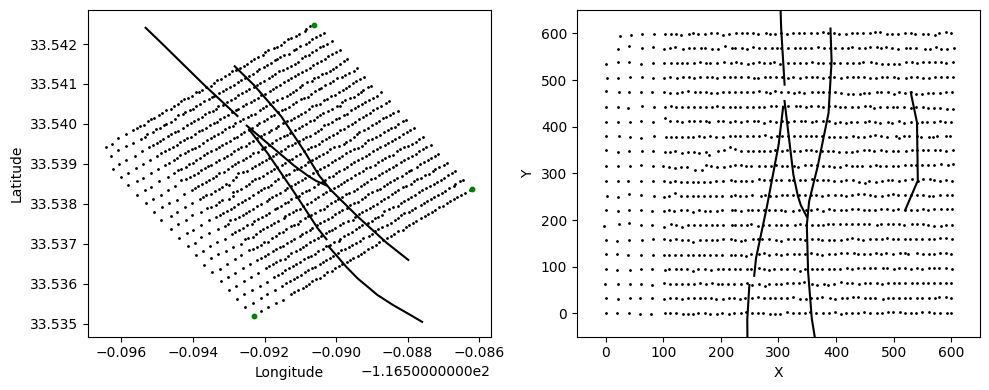

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(lon_stations_all_new, lat_stations_all_new, c='k', label='Original',s = 1)
for ref in refs:
    ax.scatter(lon_stations_all[stalist_all.index(ref)], lat_stations_all[stalist_all.index(ref)], c='g', label='Original',s = 10)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new, c='k', label='Original',s = 1)
for i in range(len(faults)):
    ax.plot(x_faults['clark'+str(i+1)], y_faults['clark'+str(i+1)], 'k')
ax.plot(x_fault_infer, y_fault_infer, 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
plt.tight_layout()

In [20]:
# generate grid
xx = np.linspace(np.min(x_centroid_partition), np.max(y_centroid_partition), num_x)
yy = np.linspace(np.min(y_centroid_partition), np.max(y_centroid_partition), num_y)
A,B = np.meshgrid(xx, yy)
X_star = np.hstack((A.flatten()[:,None], B.flatten()[:,None]))
x_grid = X_star[:,0]
y_grid = X_star[:,1]

In [21]:
vs_inter_fund = np.zeros([len(xx),len(yy),N])
vs_inter = np.zeros([len(xx),len(yy),N])
for i in range(N):
    print('Interpolating horizon %d/%d' % (i+1,N))
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter[:,:,i] = zz
    OK = OrdinaryKriging(x_centroid_partition, y_centroid_partition, vs_horizon_fund[i], variogram_model=type_interp,nlags=3)
    zz,ss = OK.execute('grid', xx, yy)
    vs_inter_fund[:,:,i] = zz

Interpolating horizon 1/40
Interpolating horizon 2/40
Interpolating horizon 3/40
Interpolating horizon 4/40
Interpolating horizon 5/40
Interpolating horizon 6/40
Interpolating horizon 7/40
Interpolating horizon 8/40
Interpolating horizon 9/40
Interpolating horizon 10/40
Interpolating horizon 11/40
Interpolating horizon 12/40
Interpolating horizon 13/40
Interpolating horizon 14/40
Interpolating horizon 15/40
Interpolating horizon 16/40
Interpolating horizon 17/40
Interpolating horizon 18/40
Interpolating horizon 19/40
Interpolating horizon 20/40
Interpolating horizon 21/40
Interpolating horizon 22/40
Interpolating horizon 23/40
Interpolating horizon 24/40
Interpolating horizon 25/40
Interpolating horizon 26/40
Interpolating horizon 27/40
Interpolating horizon 28/40
Interpolating horizon 29/40
Interpolating horizon 30/40
Interpolating horizon 31/40
Interpolating horizon 32/40
Interpolating horizon 33/40
Interpolating horizon 34/40
Interpolating horizon 35/40
Interpolating horizon 36/40
I

In [22]:
# 对vs_inter进行平滑处理,用gaussain filter
if flag_smooth == 1:
    vs_inter_smooth = np.zeros([len(xx),len(yy),N])
    vs_inter_smooth_fund = np.zeros([len(xx),len(yy),N])
    for i in range(N):
        vs_inter_smooth[:,:,i] = gaussian_filter(vs_inter[:,:,i], sigma=2)
        vs_inter_smooth_fund[:,:,i] = gaussian_filter(vs_inter_fund[:,:,i], sigma=2)

In [23]:
def cartesian_to_geographic_2d(x, y):
    # 定义一个适当的投影，根据你的数据选择合适的投影方式
    # 这里假设使用 WGS 84 椭球体投影
    proj = Proj(proj='utm', zone=10, ellps='WGS84')
    
    # 将笛卡尔坐标系转换为经纬度,单位为米
    lon, lat = proj(x, y, inverse=True)
    
    return lon, lat

In [24]:
# save as npz
z = np.arange(0,N*dz,dz)
print('Save as mat')
lons = np.zeros_like(xx)
lats = np.zeros_like(yy)
for i in range(len(xx)):
    lon, lat = cartesian_to_geographic_2d(xx[i], yy[i])
    lons[i] = lon
    lats[i] = lat
lon_stations = np.zeros_like(x_stations_in)
lat_stations = np.zeros_like(y_stations_in)
for i in range(len(x_stations_in)):
    lon, lat = cartesian_to_geographic_2d(x_stations_in[i], y_stations_in[i])
    lon_stations[i] = lon
    lat_stations[i] = lat
filename = dir_file + 'Vs_inter.mat'
savemat(filename, {'vs_inter': vs_inter, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})
filename_fund = dir_file + 'Vs_inter_fund.mat'
savemat(filename_fund, {'vs_inter_fund': vs_inter_fund, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})
if flag_smooth == 1:
    filename_smooth = dir_file + 'Vs_inter_smooth.mat'
    savemat(filename_smooth, {'vs_inter': vs_inter_smooth, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})
    filename_smooth_fund = dir_file + 'Vs_inter_smooth_fund.mat'
    savemat(filename_smooth_fund, {'vs_inter_fund': vs_inter_smooth_fund, 'x': xx-np.min(xx), 'y': yy-np.min(yy), 'z': z, 'lon_sta': lons, 'lat_sta': lats})

Save as mat


In [25]:
# save station in
lon_stations_in_new = np.zeros_like(x_stations_in)
lat_stations_in_new = np.zeros_like(y_stations_in)
for i in range(len(x_stations_in)):
    lon, lat = cartesian_to_geographic_2d(x_stations_in[i], y_stations_in[i])
    lon_stations_in_new[i] = lon
    lat_stations_in_new[i] = lat
filename = dir_file + 'sta_in.mat'
savemat(filename, {'lon_sta': lon_stations_in_new, 'lat_sta': lat_stations_in_new})
np.savetxt(dir_file+'stations_in.txt',np.array([stalist_in,stalist_in,lon_stations_in_new,lat_stations_in_new]).T,fmt='%s',delimiter=' ')

In [26]:
R_index = np.arange(5,19,2)
C_index = np.arange(12,54,5)
indexes = []
for row in R_index:
    for col in C_index:
        name = 'R'+str(col).zfill(2)+str(row).zfill(2)
        indexes.append(stalist_all.index(name))
stalist_in = np.array(stalist_all)[indexes]
lon_stations_virsrc = np.zeros_like(np.array(stalist_all)[indexes], dtype=float)
lat_stations_virsrc = np.zeros_like(np.array(stalist_all)[indexes], dtype=float)
for i in range(len(np.array(stalist_all)[indexes])):
    lon, lat = cartesian_to_geographic_2d(x_stations_all[indexes[i]], y_stations_all[indexes[i]])
    lon_stations_virsrc[i] = lon
    lat_stations_virsrc[i] = lat
filename = dir_file + 'sta_virsrc.mat'
savemat(filename, {'lon_sta': lon_stations_virsrc, 'lat_sta': lat_stations_virsrc})
np.savetxt(dir_file+'stations_virsrc.txt',np.array([stalist_in,stalist_in,lon_stations_virsrc,lat_stations_virsrc]).T,fmt='%s',delimiter=' ')


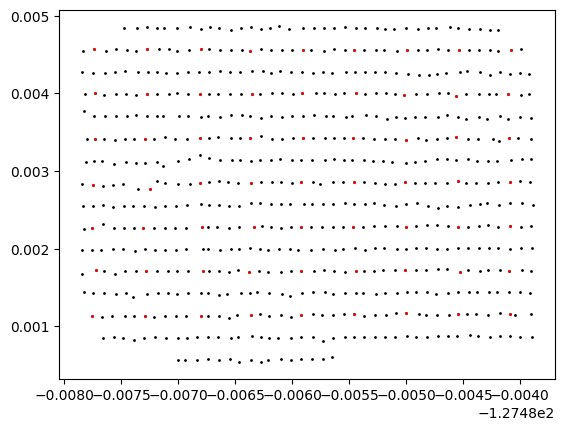

In [27]:
plt.scatter(lon_stations_in_new, lat_stations_in_new, c='k', label='Original',s = 1)
plt.scatter(lon_stations_virsrc, lat_stations_virsrc, c='r', label='Original',s = 1)

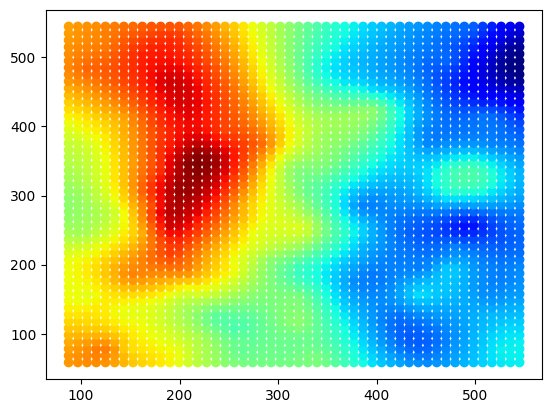

In [28]:
plt.scatter(x_grid,y_grid,c=vs_inter[:,:,22],cmap='jet')